In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("../dataset/HotelRec.csv")

### Overall Evaluation

In [9]:
class HotelRecommendationAnalysis:
    def __init__(self, data_path):
        # Load data
        self.data = pd.read_csv(data_path)
        
        # Encode categorical variables
        self.label_encoder_author = LabelEncoder()
        self.label_encoder_hotel = LabelEncoder()
        
        self.data['author_id'] = self.label_encoder_author.fit_transform(self.data['author_id'])
        self.data['hotel_id'] = self.label_encoder_hotel.fit_transform(self.data['hotel_id'])
        
        # Stratified split
        self.sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_index, test_index = next(self.sss.split(self.data, self.data['cluster']))
        
        self.train_data = self.data.iloc[train_index]
        self.test_data = self.data.iloc[test_index]
        
        # Initialize results storage
        self.results = {}

    def svd_evaluation(self):
        """Evaluate SVD for each cluster"""
        results = {}
        
        for cluster in self.data['cluster'].unique():
            # Filter data for the current cluster
            cluster_data = self.data[self.data['cluster'] == cluster]
            
            # Surprise dataset preparation
            reader = Reader(rating_scale=(1, 5))
            dataset = Dataset.load_from_df(cluster_data[['author_id', 'hotel_id', 'rating']], reader)
            
            # Train-test split
            trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)
            
            # SVD Algorithm
            algo = SVD(n_factors=90, lr_all=0.05, reg_all=0.1, biased=True)
            algo.fit(trainset)
            
            # Predictions
            predictions = algo.test(testset)
            
            # Metrics
            rmse = accuracy.rmse(predictions)
            mae = accuracy.mae(predictions)
            
            results[cluster] = {
                'RMSE': rmse,
                'MAE': mae
            }
        
        self.results['SVD'] = results
        return results

    def ncf_evaluation(self, n_latent_factors=16):
        """Evaluate Neural Collaborative Filtering for each cluster"""
        results = {}
        
        for cluster in self.data['cluster'].unique():
            # Filter data for the current cluster
            cluster_train_data = self.train_data[self.train_data['cluster'] == cluster]
            cluster_test_data = self.test_data[self.test_data['cluster'] == cluster]
            
            if len(cluster_train_data) == 0 or len(cluster_test_data) == 0:
                continue
            
            # Inputs
            author_input = Input(shape=(1,))
            hotel_input = Input(shape=(1,))
            
            # Embeddings
            n_author = len(self.label_encoder_author.classes_)
            n_hotel = len(self.label_encoder_hotel.classes_)
            
            author_embedding = Embedding(input_dim=n_author, output_dim=n_latent_factors)(author_input)
            author_flatten = Flatten()(author_embedding)
            
            hotel_embedding = Embedding(input_dim=n_hotel, output_dim=n_latent_factors)(hotel_input)
            hotel_flatten = Flatten()(hotel_embedding)
            
            # Neural network structure
            element_product = Multiply()([author_flatten, hotel_flatten])
            concat = Concatenate()([author_flatten, hotel_flatten, element_product])
            
            dense_1 = Dense(128, activation='relu')(concat)
            dropout_1 = Dropout(0.3)(dense_1)
            dense_2 = Dense(64, activation='relu')(dropout_1)
            dropout_2 = Dropout(0.3)(dense_2)
            output = Dense(1, activation='linear')(dropout_2)
            
            # Model compilation
            ncf_model = Model(inputs=[author_input, hotel_input], outputs=output)
            ncf_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
            
            # Training
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            ncf_model.fit(
                [cluster_train_data['author_id'], cluster_train_data['hotel_id']],
                cluster_train_data['rating'],
                validation_data=([cluster_test_data['author_id'], cluster_test_data['hotel_id']], 
                                 cluster_test_data['rating']),
                epochs=10, batch_size=64, callbacks=[early_stopping], verbose=0
            )
            
            # Predictions and metrics
            y_pred = ncf_model.predict([cluster_test_data['author_id'], cluster_test_data['hotel_id']])
            y_pred_rounded = np.rint(y_pred).clip(1, 5)
            
            rmse = np.sqrt(mean_squared_error(cluster_test_data['rating'], y_pred))
            mae = mean_absolute_error(cluster_test_data['rating'], y_pred)
            accuracy_score_val = accuracy_score(cluster_test_data['rating'], y_pred_rounded)
            
            results[cluster] = {
                'RMSE': rmse,
                'MAE': mae,
                'Accuracy': accuracy_score_val
            }
        
        self.results['NCF'] = results
        return results

    def hybrid_evaluation(self, n_latent_factors=8):
        """Evaluate Hybrid Recommendation Model for each cluster"""
        results = {}
        
        for cluster in self.data['cluster'].unique():
            # Filter data for the current cluster
            cluster_train_data = self.train_data[self.train_data['cluster'] == cluster]
            cluster_test_data = self.test_data[self.test_data['cluster'] == cluster]
            
            if len(cluster_train_data) == 0 or len(cluster_test_data) == 0:
                continue
            
            # Inputs
            n_author = len(self.label_encoder_author.classes_)
            n_hotel = len(self.label_encoder_hotel.classes_)
            
            author_input = Input(shape=(1,))
            hotel_input = Input(shape=(1,))
            senti_score_input = Input(shape=(1,))
            year_input = Input(shape=(1,))
            
            # Embeddings
            author_embedding = Embedding(input_dim=n_author, output_dim=n_latent_factors)(author_input)
            author_flatten = Flatten()(author_embedding)
            
            hotel_embedding = Embedding(input_dim=n_hotel, output_dim=n_latent_factors)(hotel_input)
            hotel_flatten = Flatten()(hotel_embedding)
            
            # Hybrid model structure
            element_product = Multiply()([author_flatten, hotel_flatten])
            concat = Concatenate()([author_flatten, hotel_flatten, element_product, senti_score_input, year_input])
            
            dense_1 = Dense(128, activation='relu')(concat)
            dropout_1 = Dropout(0.3)(dense_1)
            dense_2 = Dense(64, activation='relu')(dropout_1)
            dropout_2 = Dropout(0.3)(dense_2)
            output = Dense(1, activation='linear')(dropout_2)
            
            # Model compilation
            hybrid_model = Model(inputs=[author_input, hotel_input, senti_score_input, year_input], outputs=output)
            hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
            
            # Training
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            hybrid_model.fit(
                [cluster_train_data['author_id'], 
                 cluster_train_data['hotel_id'], 
                 cluster_train_data['senti_score'], 
                 cluster_train_data['year']],
                cluster_train_data['rating'],
                validation_data=([cluster_test_data['author_id'], 
                                  cluster_test_data['hotel_id'], 
                                  cluster_test_data['senti_score'], 
                                  cluster_test_data['year']],
                                 cluster_test_data['rating']),
                epochs=10, batch_size=64, callbacks=[early_stopping], verbose=0
            )
            
            # Predictions and metrics
            y_pred = hybrid_model.predict([
                cluster_test_data['author_id'], 
                cluster_test_data['hotel_id'], 
                cluster_test_data['senti_score'], 
                cluster_test_data['year']
            ])
            y_pred_rounded = np.rint(y_pred).clip(1, 5)
            
            rmse = np.sqrt(mean_squared_error(cluster_test_data['rating'], y_pred))
            mae = mean_absolute_error(cluster_test_data['rating'], y_pred)
            accuracy_score_val = accuracy_score(cluster_test_data['rating'], y_pred_rounded)
            
            results[cluster] = {
                'RMSE': rmse,
                'MAE': mae,
                'Accuracy': accuracy_score_val
            }
        
        self.results['Hybrid'] = results
        return results

    def plot_comparative_metrics(self):
        """Plot comparative metrics across clusters for different models"""
        plt.figure(figsize=(15, 5))
        
        # RMSE Comparison
        plt.subplot(131)
        rmse_data = {
            model: [metrics['RMSE'] for metrics in results.values()]
            for model, results in self.results.items()
        }
        plt.boxplot(list(rmse_data.values()), labels=list(rmse_data.keys()))
        plt.title('RMSE Comparison')
        plt.ylabel('RMSE')
        
        # MAE Comparison
        plt.subplot(132)
        mae_data = {
            model: [metrics['MAE'] for metrics in results.values()]
            for model, results in self.results.items()
        }
        plt.boxplot(list(mae_data.values()), labels=list(mae_data.keys()))
        plt.title('MAE Comparison')
        plt.ylabel('MAE')
        
        # Accuracy Comparison (for models that support it)
        plt.subplot(133)
        accuracy_data = {
            model: [metrics.get('Accuracy', 0) for metrics in results.values()]
            for model, results in self.results.items()
            if 'Accuracy' in list(results.values())[0]
        }
        plt.boxplot(list(accuracy_data.values()), labels=list(accuracy_data.keys()))
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        
        plt.tight_layout()
        plt.show()

In [10]:
# Usage
path = "../dataset/HotelRec.csv"
analysis = HotelRecommendationAnalysis(path)

In [ ]:
analysis.svd_evaluation()

RMSE: 0.9397
MAE:  0.7275
RMSE: 0.7989
MAE:  0.5877
RMSE: 0.8294
MAE:  0.6310


{2: {'RMSE': 0.9396521789182896, 'MAE': 0.7274613586221939},
 1: {'RMSE': 0.7989498730810167, 'MAE': 0.587727521715593},
 0: {'RMSE': 0.8293576647367522, 'MAE': 0.6310178614979198}}

In [12]:
analysis.ncf_evaluation()

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 7s 314us/step
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 9s 312us/step
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 7s 315us/step


{2: {'RMSE': 0.9402750346159338,
  'MAE': 0.7318128321090027,
  'Accuracy': 0.4216238783886331},
 1: {'RMSE': 0.800082126405072,
  'MAE': 0.5934303202120103,
  'Accuracy': 0.5397128298911351},
 0: {'RMSE': 0.8275546919914023,
  'MAE': 0.6363810303036488,
  'Accuracy': 0.4883553065781698}}

In [13]:
analysis.hybrid_evaluation()

22979/22979 ━━━━━━━━━━━━━━━━━━━━ 9s 406us/step
28298/28298 ━━━━━━━━━━━━━━━━━━━━ 10s 355us/step
21734/21734 ━━━━━━━━━━━━━━━━━━━━ 8s 349us/step


{2: {'RMSE': 0.7994644429061314,
  'MAE': 0.6313896258512014,
  'Accuracy': 0.47480845230550806},
 1: {'RMSE': 0.6971998802555467,
  'MAE': 0.5397281891867383,
  'Accuracy': 0.579812175464868},
 0: {'RMSE': 0.7404436194019246,
  'MAE': 0.5859787859503516,
  'Accuracy': 0.5039275767218286}}

/var/folders/r2/3wggt_vs5jncfc0txj7dtys80000gn/T/ipykernel_45291/1676530710.py:214: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(rmse_data.values()), labels=list(rmse_data.keys()))
/var/folders/r2/3wggt_vs5jncfc0txj7dtys80000gn/T/ipykernel_45291/1676530710.py:224: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(mae_data.values()), labels=list(mae_data.keys()))
/var/folders/r2/3wggt_vs5jncfc0txj7dtys80000gn/T/ipykernel_45291/1676530710.py:235: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(accuracy_data.values()), labels=list(accuracy_data.keys()))


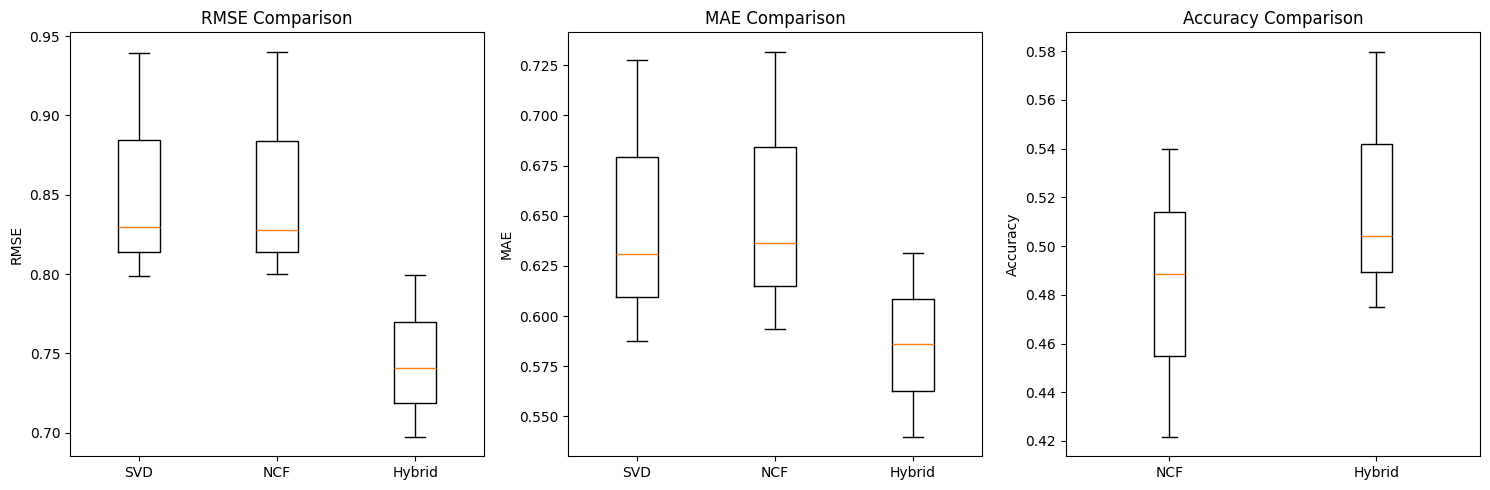

In [ ]:
analysis.plot_comparative_metrics()

In [ ]:
print("SVD Results per Cluster:")
for cluster, metrics in analysis.results['SVD'].items():
    print(f"Cluster {cluster}: {metrics}")

print("\nNCF Results per Cluster:")
for cluster, metrics in analysis.results['NCF'].items():
    print(f"Cluster {cluster}: {metrics}")

print("\nHybrid Results per Cluster:")
for cluster, metrics in analysis.results['Hybrid'].items():
    print(f"Cluster {cluster}: {metrics}")

SVD Results per Cluster:
Cluster 2: {'RMSE': 0.9396521789182896, 'MAE': 0.7274613586221939}
Cluster 1: {'RMSE': 0.7989498730810167, 'MAE': 0.587727521715593}
Cluster 0: {'RMSE': 0.8293576647367522, 'MAE': 0.6310178614979198}

NCF Results per Cluster:
Cluster 2: {'RMSE': 0.9402750346159338, 'MAE': 0.7318128321090027, 'Accuracy': 0.4216238783886331}
Cluster 1: {'RMSE': 0.800082126405072, 'MAE': 0.5934303202120103, 'Accuracy': 0.5397128298911351}
Cluster 0: {'RMSE': 0.8275546919914023, 'MAE': 0.6363810303036488, 'Accuracy': 0.4883553065781698}

Hybrid Results per Cluster:
Cluster 2: {'RMSE': 0.7994644429061314, 'MAE': 0.6313896258512014, 'Accuracy': 0.47480845230550806}
Cluster 1: {'RMSE': 0.6971998802555467, 'MAE': 0.5397281891867383, 'Accuracy': 0.579812175464868}
Cluster 0: {'RMSE': 0.7404436194019246, 'MAE': 0.5859787859503516, 'Accuracy': 0.5039275767218286}
